## Clustering
Clustering problem is basically an optimization problem. Solving this optimization problem is computationally prohibitive for most interesting problems. Consequently people rely on greedy algorithms that provide approximate solutions. One such abstraction is the k-means clustering problem

Before going into k-means clustering, lets look at some abstractions we will need to study that

In [91]:
from math import *
from decimal import Decimal

def minkowski_distance(x, y, p):
    return pow(sum(pow(abs(a-b), p) for a, b in zip(x, y)), 1/float(p))

Class Example will be used to build the samples to be clustered. Associated with each example is a name, a feature vector, and an optional label. The distance method returns the Euclidean distance between two examples.

In [92]:
class Example(object):
    def __init__(self, name, features, label=None):
        #Assumes features is an array of numbers
        self.name = name
        self.features = features
        self.label = label
    
    def dimensionality(self):
        return len(self.features)
    
    def getFeatures(self):
        return self.features[:]
    
    def getLabel(self):
        return self.label
    
    def getName(self):
        return self.name
    
    def distance(self, other):
        return minkowski_distance(self.features, other.features, 2)
    
    def __str__(self):
        return self.name + ":" + str(self.features) + ":" + str(self.label)
    
    

Class Cluster can be thought of as a set of examples. The two interesting methods in Cluster are computeCentroid and variance. 

Think of centroid of a cluster as its center of mass. The method computeCentroid returns an example with a feature vector equal to the Euclidean mean of the feature vectors of the examples.

The method variance provides a measure of the coherence of the cluster.

In [93]:
class Cluster(object):
    def __init__(self, examples, exampleType):
        """Assumes examples is a list of examples of type exampleType"""
        self.examples = examples
        self.exampleType = exampleType
        self.centroid = self.computeCentroid()
        
    def update(self, examples):
        """
        Replace the examples in the cluster by new examples
        Return how much the centroid has changed
        """
        oldCentroid = self.centroid
        self.examples = examples
        if len(examples) > 0:
            self.centroid = self.computeCentroid()
            return oldCentroid.distance(self.centroid)
        else:
            return 0.0
            
    def members(self):
        for e in self.examples:
            yield e
    
    def size(self):
        return len(self.examples)
    
    def getCentroid(self):
        return self.centroid
    
    def computeCentroid(self):
        dim = self.examples[0].dimensionality()
        totVals = pylab.array([0.0]*dim)
        for e in self.examples:
            totVals += e.getFeatures()
        centroid = self.exampleType('centroid', totVals/float(len(self.examples)))
        
        return centroid
    
    def variance(self):
        totDist = 0.0
        for e in self.examples:
            totDist += (e.distance(self.centroid))**2
        
        return totDist**0.5
    
    def __str__(self):
        names = []
        for e in self.examples:
            names.append(e.getName())
        names.sort()
        result = 'Cluster with centroid ' + str(self.centroid.getFeatures()) + ' contains:\n '
        for e in names:
            result = result + e + ', '
        return result[:-2]

### K-means Clustering
K-means clustering is the most widely used clustering method. Its goal is to partition a set of examples into k clusters such that

* Each example is in the cluster whose centroid is the closest centroid to that example
* The dissimilarity of the set of clusters is minimized

Finding an optimal solution to this problem on a large dtaset is computationally intractable. However there is a greedy solution

Randomly choose k examples as initial centroids
while true:
* create k clusters by assigning each example to closest centroid
* compute k new centroids by averaging the examples in each cluster
* if none of the centroids differ from the previous iteration: return the current set of clusters

One problem with k-means is it is non-deterministic. The value returned depends upon the initial set of randomly chosen centroids. This is typically addressed by running k-means multiple times with randomly chosen initial centroids. We then choose the solution with the minimum dissimilarity of clusters.

Though k-means is the most commonly used clustering method, it is not the most appropriate method in all situations. Two other widely used methods not covered in this book are hierarchical clustering and EM-clustering.

In [94]:
def kmeans(examples, exampleType, k, verbose):
    """
    Assumes examples is a list of examples of type exampleType,
    k is a positive int, vervose is a boolean.
    
    Return: list containing k clusters. If verbose is True it prints result of each iteration of k-means
    """
    # Get k randomly chosen initial centroids
    initialCentroids = random.sample(examples, k)
    
    # Create a singleton cluster for each centroid
    clusters = []
    for e in initialCentroids:
        clusters.append(Cluster([e], exampleType))
        
    # Iterate until the centroids do not change
    converged = False
    numIterations = 0
    while not converged:
        numIterations += 1
        # Create a list containing k distinct empty lists
        newClusters =[]
        for i in range(k):
            newClusters.append([])
        
        # Associate each example with closest centroid
        for e in examples:
            # Find the centroid closest to e
            smallestDistance = e.distance(clusters[0].getCentroid())
            index = 0
            for i in range(1, k):
                distance = e.distance(clusters[i].getCentroid())
                if distance < smallestDistance:
                    smallestDistance = distance
                    index = i
            # Add e to the list of examples for the appropriate cluster
            newClusters[index].append(e)
            
        # Update each cluster; check if centroid has changed
        converged = True
        for i in range(len(clusters)):
            if clusters[i].update(newClusters[i]) > 0.0:
                converged = False
        if verbose:
            print('Iteration #' + str(numIterations))
            for c in clusters:
                print(c)
            print('') # add blank line
    return clusters

def dissimilarity(clusters):
    totDist = 0.0
    for c in clusters:
        totDist += c.variance()
    return totDist

def trykmeans(examples, exampleType, numClusters, numTrials, verbose=False):
    """
    Calls kmeans numTrials times and returns the result with the lowest dissimilarity
    """
    best = kmeans(examples, exampleType, numClusters, verbose)
    minDissimilarity = dissimilarity(best)
    for trial in range(1, numTrials):
        clusters = kmeans(examples, exampleType, numClusters, verbose)
        currDissimilarity = dissimilarity(clusters)
        if currDissimilarity < minDissimilarity:
            best = clusters
            minDissimilarity = currDissimilarity
    return best

### Contrived Example

The function genDistributions generates a list of n examples with two-dimensional feature vectors. The values of the elements of these feature vectors are drawn from normal distribution

The function plotSamples plots the feature vectors of a set of examples. It uses another pylab plotting feature that we have not seen yet: the function 'annotate' is used to place text next to points on the plot. The first arg is the text, second the point with which the text is associated, third the location of text relative to the point with which it is associated.

The function contrivedTest uses genDistributions to create two distributions of ten examples each with the same standard deviation but different means, plots the examples using plotSamples and then clusters them using trykmeans.

In [95]:
import random
import pylab

def genDistribution(xMean, xSD, yMean, ySD, n, namePrefix):
    samples = []
    for s in range(n):
        x = random.gauss(xMean, xSD)
        y = random.gauss(yMean, ySD)
        samples.append(Example(namePrefix+str(s), [x, y]))
    return samples

def plotSamples(samples, marker):
    xVals, yVals = [], []
    for s in samples:
        x = s.getFeatures()[0]
        y = s.getFeatures()[1]
        pylab.annotate(s.getName(), xy = (x, y), xytext = (x+0.13, y-0.07), fontsize = 'x-large')
        xVals.append(x)
        yVals.append(y)
    pylab.plot(xVals, yVals, marker)
    
def contrivedTest(numTrials, k, verbose):
    random.seed(0)
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 10
    d1Samples = genDistribution(xMean, xSD, yMean, ySD, n, '1. ')
    %matplotlib inline
    plotSamples(d1Samples, 'b^')
    d2Samples = genDistribution(xMean+3, xSD, yMean+1, ySD, n, '2. ')
    plotSamples(d2Samples, 'ro')
    d3Samples = genDistribution(xMean, xSD, yMean+3, ySD, n, '3.')
    plotSamples(d3Samples, 'gd')
    clusters = trykmeans(d1Samples + d2Samples + d3Samples, Example, k, numTrials, verbose)
    print('Final result')
    for c in clusters:
        print('', c)
    

Final result
 Cluster with centroid [ 3.44626677  8.14586916] contains:
 1. 6, 2. 0, 2. 6, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9
 Cluster with centroid [ 4.51930758  4.87457125] contains:
 1. 0, 1. 1, 1. 2, 1. 3, 1. 4, 1. 5, 1. 7, 1. 8, 1. 9, 2. 1, 2. 2, 2. 3, 2. 4, 2. 5, 2. 7, 2. 8, 2. 9


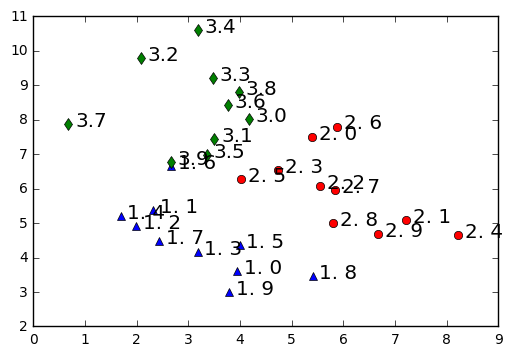

In [96]:
contrivedTest(40, 2, False)

Final result
 Cluster with centroid [ 3.57078877  7.91578419] contains:
 1. 6, 2. 0, 2. 3, 2. 5, 2. 6, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9
 Cluster with centroid [ 6.38874689  4.98963434] contains:
 1. 8, 2. 1, 2. 2, 2. 4, 2. 7, 2. 8, 2. 9
 Cluster with centroid [ 2.91832962  4.38747589] contains:
 1. 0, 1. 1, 1. 2, 1. 3, 1. 4, 1. 5, 1. 7, 1. 9


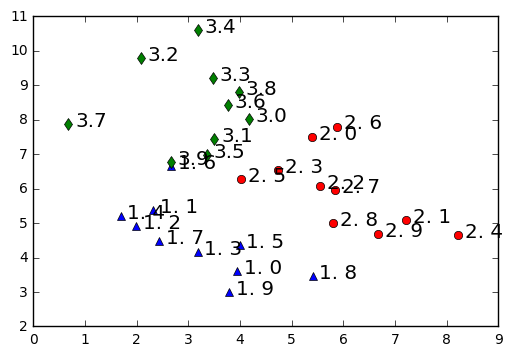

In [97]:
contrivedTest(40, 3, False)

Final result
 Cluster with centroid [ 2.10900238  4.99452866] contains:
 1. 1, 1. 2, 1. 4, 1. 7
 Cluster with centroid [ 6.21790632  5.3627529 ] contains:
 2. 1, 2. 2, 2. 7, 2. 8, 2. 9
 Cluster with centroid [ 8.22757729  4.64475851] contains:
 2. 4
 Cluster with centroid [ 3.57078877  7.91578419] contains:
 1. 6, 2. 0, 2. 3, 2. 5, 2. 6, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9
 Cluster with centroid [ 3.5862231   4.26095958] contains:
 1. 3, 1. 5
 Cluster with centroid [ 4.38076686  3.35623026] contains:
 1. 0, 1. 8, 1. 9


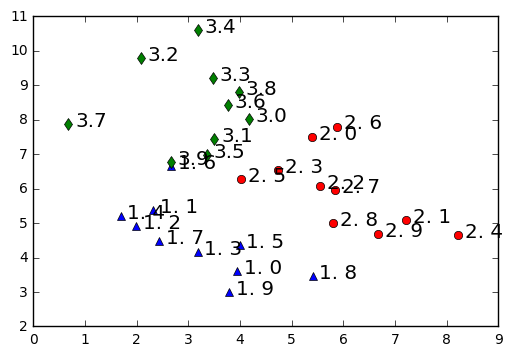

In [99]:
contrivedTest(40, 6, False)